# Learn Curve fit params, Temperature Split

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import surfreact.mlutils as mlut
import sklearn.preprocessing
import joblib
import reaxnet.io.molml
import molml.molecule

import scipy
from scipy.optimize import curve_fit

## 1. Load dataset

In [2]:
MLdataset = mlut.load_MLdataset('../../../data/MLdataset/')

In [3]:
MLdataset = MLdataset.sort_values('reaction_id').reset_index(drop = True)

### Load cff values:

Here load every cff value for time less than 4000

In [4]:
selected_cffvals = {}
selected_cfftimes = {}
selected_cfft0vals = {}

time_count = 0

for i, row in MLdataset.iterrows():
    rxnID = row.reaction_id
    templist = row.Temperature_list
    #print(rxnID)
    
    rxn_cffvals = {}
    rxn_times = {}
    rxn_cfft0vals = []
    
    for T in templist:
        #print(T)
        Cffdata = pd.read_csv('../../../data/MLdataset/cff_timeseries/rxn{}/CffValues_reaction{}_temp{}.csv'.format(rxnID, rxnID, int(T)))
        
        times = Cffdata.time_AU.to_numpy()
        t4000 = times[times < 4000]
        # Can either select a subset of times to include, or use all
        cff_vals = []
        
        for j, t in enumerate(t4000):
            Cffrow = Cffdata[Cffdata.time_AU == t]
            cff_vals.append(float(Cffrow['CFFval']))                   
            time_count += 1
            
        # get time=0 and append to dataset
        Cff_t0 = Cffdata[Cffdata.time_AU == 0]
        rxn_cfft0vals.append(float(Cff_t0['CFFval']))
            
        rxn_cffvals[str(T)] = cff_vals
        rxn_times[str(T)] = t4000
        
            
    selected_cffvals[str(rxnID)] = rxn_cffvals
    selected_cfftimes[str(rxnID)] = rxn_times
    selected_cfft0vals[str(rxnID)] = rxn_cfft0vals    

### Unwrap this into a dataframe of rxn ID, temp, cff times, cffvals

In [5]:
rxids = []
temps = []
times = []
cffvals = []
cffvals_scaled_list = []
cff0_list = []

for i, row in MLdataset.iterrows():
    rxnID = row.reaction_id
    templist = row.Temperature_list
    
    for k, T in enumerate(templist):
        
        rxids.append(rxnID)
        temps.append(T)
        times.append(selected_cfftimes[str(rxnID)][str(T)])
        
        # normalize cff vals by cff0
        
        cffvalues_now = selected_cffvals[str(rxnID)][str(T)]
        cff0 = selected_cfft0vals[str(rxnID)][k]
        
        cffvals_scaled = [cff/cff0 for cff in cffvalues_now]
        
        cffvals.append(cffvalues_now)
        cffvals_scaled_list.append(cffvals_scaled)
        cff0_list.append(cff0)

In [6]:
cff_df = pd.DataFrame({'reactionID':rxids, 'temperature':temps, 'times':times, 'cffvals_unscaled':cffvals, 'cffvals_scaled':cffvals_scaled_list,  'cff0':cff0_list})

## 2. Fit Cauchy distributions

In [7]:
def cauchy(x, scale):
    
    a = np.pi* scale
    b = 0.0
    loc = 0.0
    return a * scipy.stats.cauchy.pdf(x, loc, scale) + b  

In [8]:

def get_new_t_cff(times, cffs):
    
    all_times = []
    all_cffs = []
    
    for elem in range(len(times)):
        
        new_times = []
        new_cffs = []
        
        neg_times = -times[elem][::-1]
        neg_cffs = cffs[elem][::-1]
        
        for i in range(len(neg_times)-1):
            if neg_times[i] > -4000:
                new_times.append(neg_times[i])
                new_cffs.append(abs(neg_cffs[i]))
                
        new_times.append(0.0)
        new_cffs.append(1.0)
        
        for j in range(len(times[elem])-1):
            if times[elem][j+1] < 4000:
                new_times.append(times[elem][j+1])
                new_cffs.append(abs(cffs[elem][j+1]))
                
        #new_cffs = np.zeros(len(neg_times)*2-1)
        #i = 1
        #for k in range(len(cffs[elem].values)*2-1):
        #    if i < len(neg_times):
        #        new_cffs[k] = cffs[elem].values[-i]
        #    else:
        #        new_cffs[k] = cffs[elem].values[i-len(neg_times)]
        #    i+=1
        
        all_times.append(new_times)
        all_cffs.append(new_cffs)
        
    return all_times, all_cffs

In [9]:
all_times, all_cffs = get_new_t_cff(times, cffvals_scaled_list)

In [10]:
popts_cauchy = []
pcovs_cauchy = []

for ind in range(len(all_times)):
    #print(ind)
    #print(all_times[ind])
    #print(all_cffs[ind])
    #plt.plot(all_times[ind], all_cffs[ind],'r')
    g = 500
    
    #plt.plot(all_times[ind], cauchy(all_times[ind], ),'-b')
    popt, pcov = curve_fit(cauchy, all_times[ind], all_cffs[ind], p0 = [g], maxfev=5000)
    popts_cauchy.append(popt)
    pcovs_cauchy.append(pcov)

/var/folders/5w/njl31sq100d2n48hkrxy6d_h0000gn/T/ipykernel_2219/4134346277.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


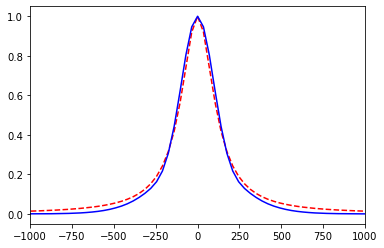

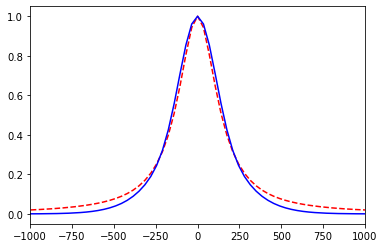

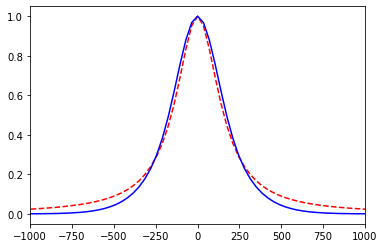

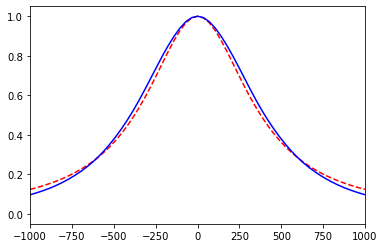

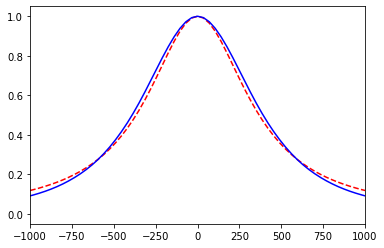

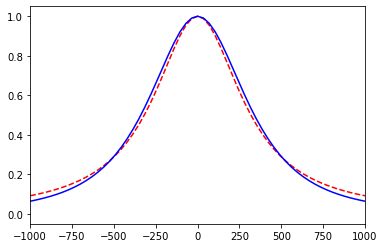

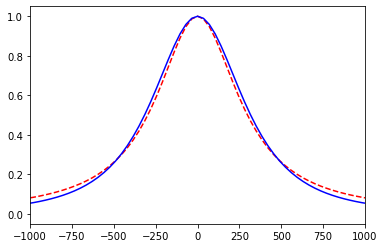

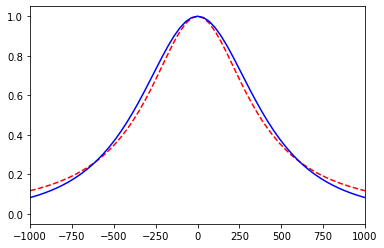

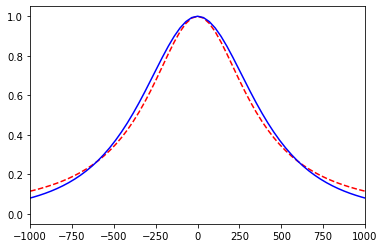

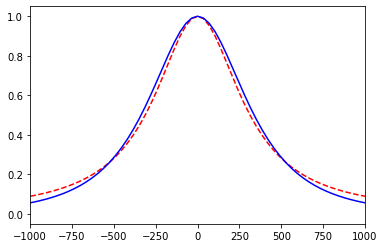

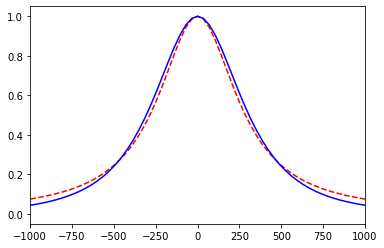

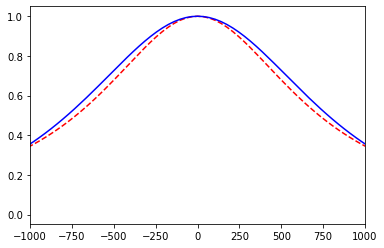

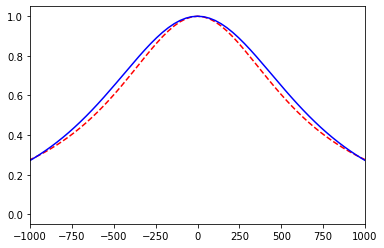

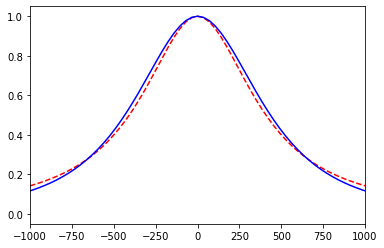

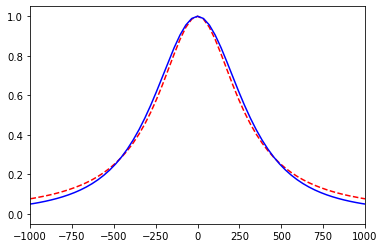

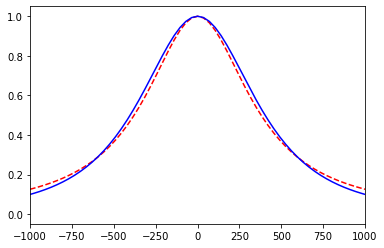

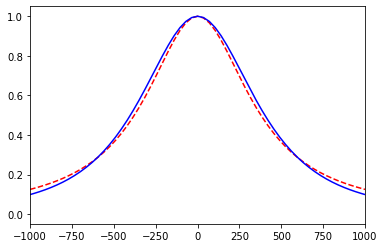

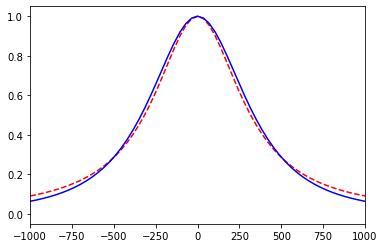

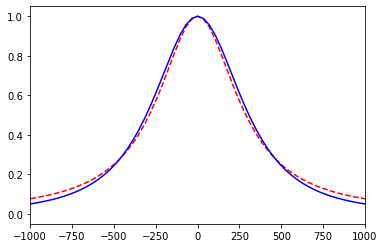

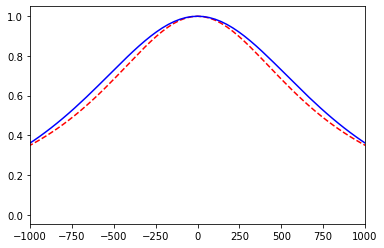

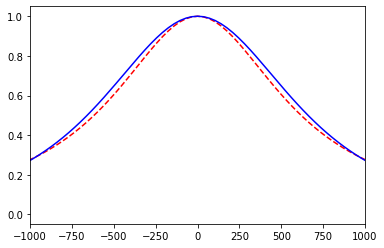

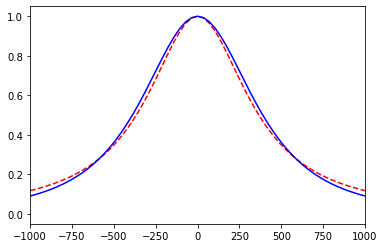

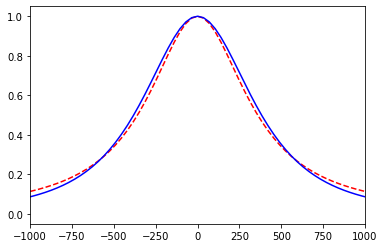

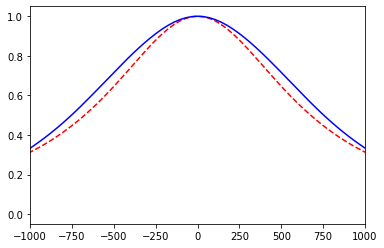

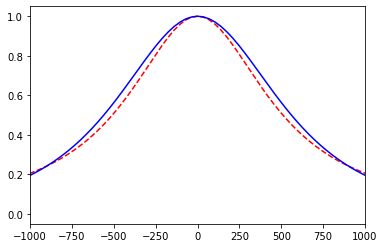

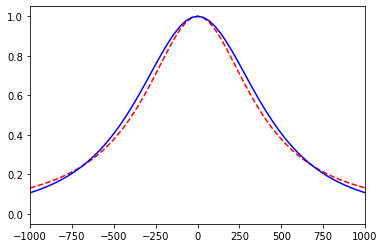

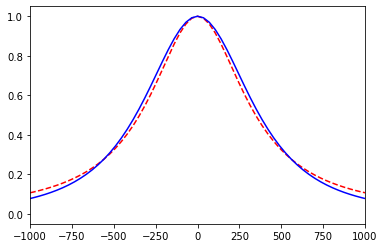

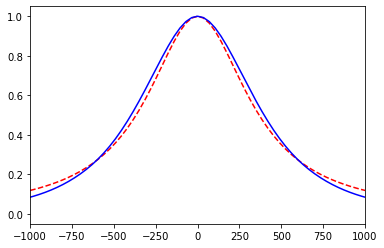

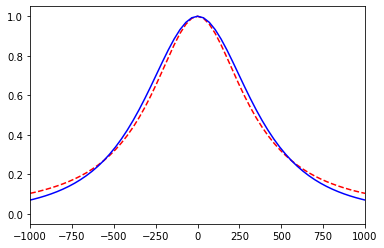

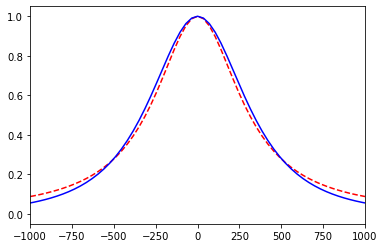

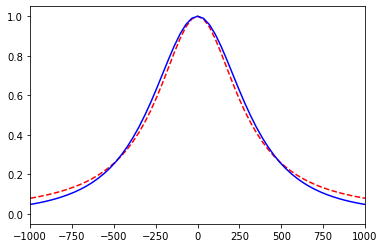

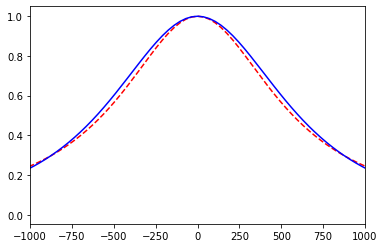

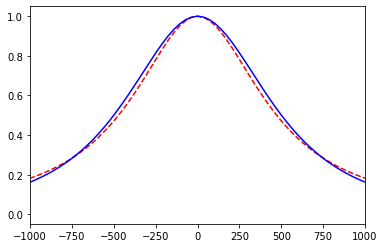

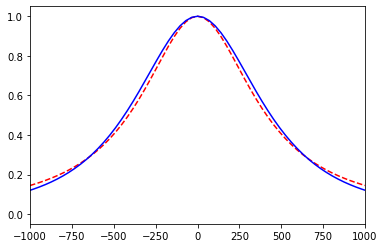

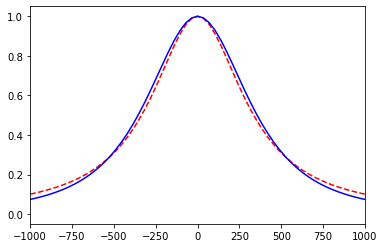

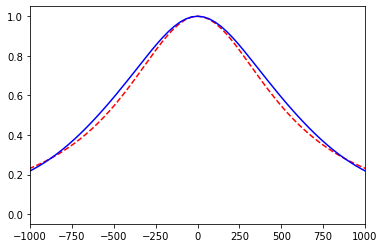

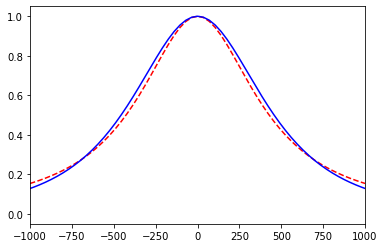

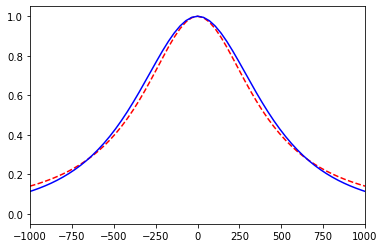

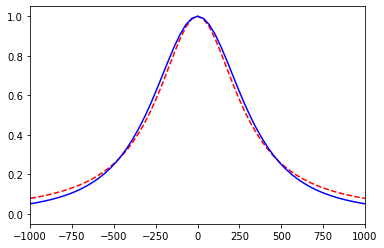

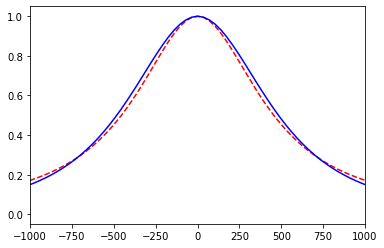

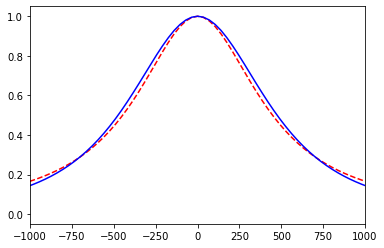

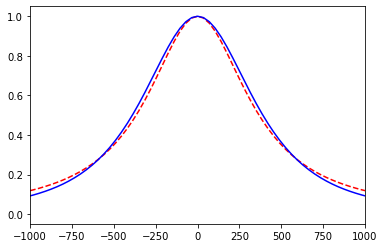

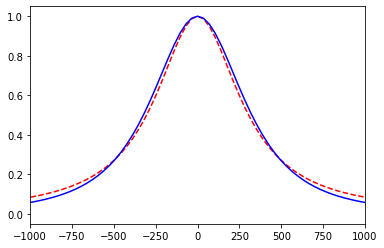

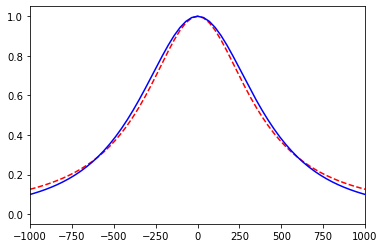

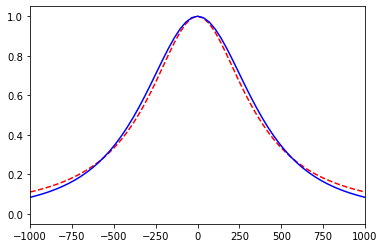

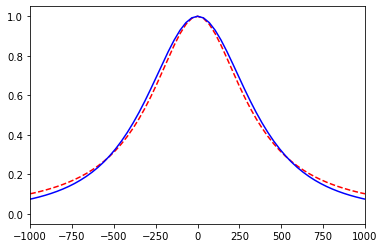

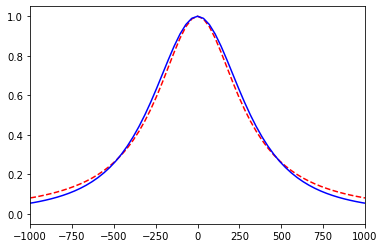

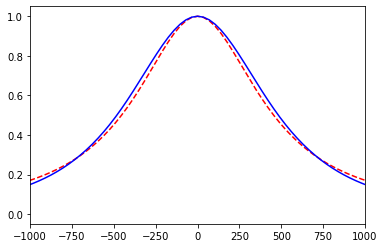

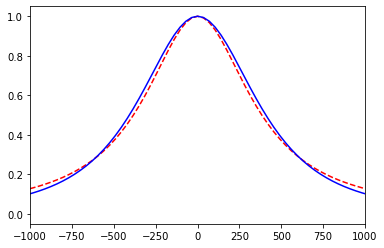

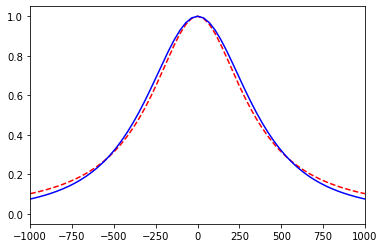

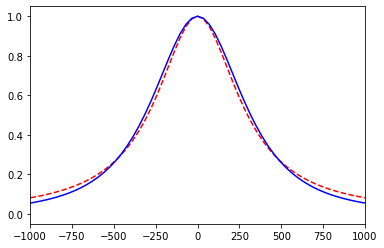

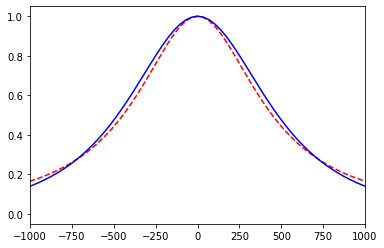

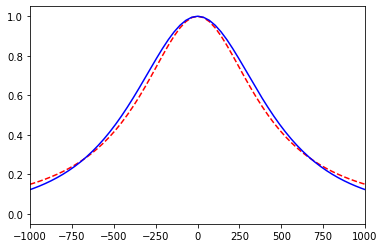

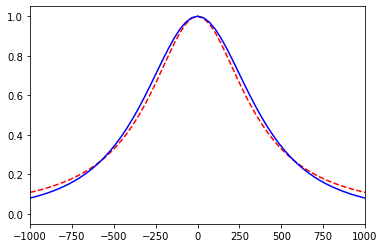

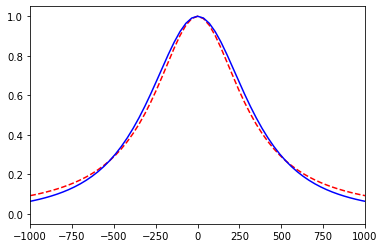

In [11]:
for ind in range(len(all_times)):
    plt.figure()
    plt.plot(all_times[ind], cauchy(all_times[ind], *popts_cauchy[ind]), 'r--')
    plt.plot(all_times[ind], all_cffs[ind],'-b')
    plt.xlim([-1000,1000])

In [12]:
scale = []
[scale.append(param[0]) for param in popts_cauchy];

In [13]:
cff_df['scale'] = scale
cff_df['cff_t0'] = cff0_list

## 3. Generate coulomb matrix features

In [14]:
react_selected_list = []
prod_selected_list = []

for i, row in MLdataset.iterrows():
    
    print(row.reaction_id)
    
    react = row.reactant_geom
    prod = row.product_geom
    
    react_selected, prod_selected = mlut.get_moving_atoms(react, prod, 6)
    #print(react_selected.get_chemical_symbols())
    react_selected_list.append(react_selected)
    prod_selected_list.append(prod_selected)

4105
[171 170 147 143 142 146]
4119
[36 38 37 28 30 31]
4127
[162 164 161 163 135 125]
4128
[99 98 96 97 81 84]
82687
[174 173 172 170 171 144]
82736
[171 170 172 148 150 149]
82754
[173 170 172 171 121 124]
82755
[173 170 172 171 121 122]
82769
[171 173 170 172 147 143]
82826
[171 173 172 170 148 150]
82843
[170 172 171 151 149 148]
432820
[30 27 29 28 25 22]
432827
[29 28 27 22 19 25]
432887
[29 28 27 19 18 25]


In [15]:
MLdataset['selected_reactant_atoms'] = react_selected_list
MLdataset['selected_product_atoms'] = prod_selected_list

In [16]:
reactants = []
products = []

for i, row in MLdataset.iterrows():
    reactants.append(row.selected_reactant_atoms)
    products.append(row.selected_product_atoms)

In [17]:
allgeoms = reactants + products

In [18]:
CM_input = [reaxnet.io.molml.atoms_to_molmllist(geom) for geom in allgeoms]

In [19]:
feat = molml.molecule.CoulombMatrix()

features = feat.fit_transform(CM_input)

In [20]:
reactant_feats = features[0:int(len(features)/2)]
product_feats = features[int(len(features)/2):]

CM_diff = [react - prod for prod, react in zip(product_feats, reactant_feats)]

In [21]:
geom_features = np.zeros((len(MLdataset), 36))

In [22]:
for i, feat in enumerate(CM_diff):
    geom_features[i,:] = feat

## 4. Concatenate features into input and target arrays

In [23]:
X, kQ_true = mlut.concatenate_features_kQ(geom_features, MLdataset, log_cff = False)

In [24]:
X.shape

(55, 39)

In [25]:
cff_df['kQ_cff'] = kQ_true

In [26]:
y = np.array(scale)

## 5. Train-test split based on temperatures

In [27]:
X_train_indexed, X_test_indexed, y_train, y_test, test_inds = mlut.temperature_split(X, y, MLdataset, return_inds = True)

In [28]:
len(X_train_indexed) + len(X_test_indexed) == len(X)

True

In [29]:
for i in range(0, len(X_test_indexed)):
    row = X_test_indexed[i,:]
    for j in range(0, len(X_train_indexed)):
        
        train_row = X_train_indexed[j, 1]
    
        assert not np.equal(row, train_row).all(), 'matching rows found'

In [30]:
X_train = X_train_indexed[:, 1:]
X_test = X_test_indexed[:, 1:]

In [31]:
traintest = ['train']*55

In [32]:
for i in range(len(traintest)):
    if i in test_inds:
        traintest[i] = 'test'

In [33]:
cff_df['traintest_split'] = traintest

## 6. Scale features

### Scale X using minmax scaler

In [34]:
scaler = sklearn.preprocessing.MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Scale y using minmax

#### Save train-ready outputs

In [35]:
#np.save('X_train_cfftimeseries_CMdiff_rxnsplit_scaled.npy', X_train)
#np.save('y_train_cfftimeseries_CMdiff_rxnsplit_scaled.npy', y_train)
#np.save('X_test_cfftimeseries_CMdiff_rxnsplit_scaled.npy', X_test)
#np.save('y_test_cfftimeseries_CMdiff_rxnsplit_scaled.npy', y_test)

## 7. Train Model

In [38]:
LS = 1
scale_min = 1e-5
scale_max = 1e5
Nr = 50
RS = 27
alpha = 5e-1

In [39]:
kernel = 1 * sklearn.gaussian_process.kernels.Matern(length_scale=LS, length_scale_bounds=(scale_min, scale_max))+1*sklearn.gaussian_process.kernels.RationalQuadratic()

gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel = kernel, normalize_y = False, n_restarts_optimizer=Nr, random_state=RS, alpha=alpha)

gpr.fit(X_train, y_train)

/Users/bgpelkie/miniconda3/envs/cfflearning/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/bgpelkie/miniconda3/envs/cfflearning/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.5,
                         kernel=1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * RationalQuadratic(alpha=1, length_scale=1),
                         n_restarts_optimizer=50, random_state=27)

## 8. Evaluate Model

In [45]:
predicted_params_train = gpr.predict(X_train)
mae_train = sklearn.metrics.mean_absolute_error(y_train, predicted_params_train)
MAPE_train = sklearn.metrics.mean_absolute_percentage_error(y_train, predicted_params_train)*100
print('train mae: ', mae_train)
print('train mape: ', MAPE_train)

train mae:  0.04710091336421112
train mape:  0.01936365872879117


In [46]:
predicted_param, param_std = gpr.predict(X_test, return_std=True)

In [47]:
test_params  = y_test

### Parameter Prediction

In [48]:
r2_param = sklearn.metrics.r2_score(predicted_param, test_params)
MAE_param = sklearn.metrics.mean_absolute_error(predicted_param, test_params)
MAPE_param = sklearn.metrics.mean_absolute_percentage_error(test_params, predicted_param)*100

In [49]:
print(r2_param)
print(MAE_param)
print('MAPE for parameters, table 1: ', MAPE_param)

0.9977744106745446
3.2473083713271143
MAPE for parameters, table 1:  1.0435348735417542


## Parity plot

(98.80912069240347, 754.0531515940622)

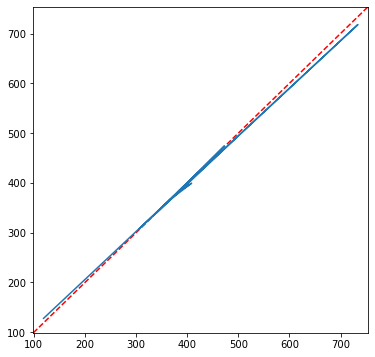

In [50]:
plt.figure(figsize = (6,6))


xmin = min(min(test_params), min(predicted_param))-20
xmax = max(max(test_params), max(predicted_param))+20


identity = np.linspace(xmin, xmax, 1000)
plt.plot(identity, identity, ls = '--', color = 'red')

plt.errorbar(test_params, predicted_param)

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)


#plt.title('Reaction Split, Curve fit learn')
#plt.xlabel(r'$\log(kQ_{C_{ff}})$, True')
#plt.ylabel(r'$\log(kQ_{C{ff}})$, Curve Fit integration')

## Predicted Fit vs Curve Fit

Plot fit curves vs curves with model predicted parameters

0.004406650213068947
5.36573974879223e-05
5.023853767950713e-05
0.0038826493902107844
4.272731575773598e-07
0.005618821010843299
0.0020441550354207616
0.0002477864381897838
0.0005760687618051456
4.638030149637905e-05
0.0007027614097324872
0.00012508651996081502
0.00023480684274974185
0.00016629907669126438


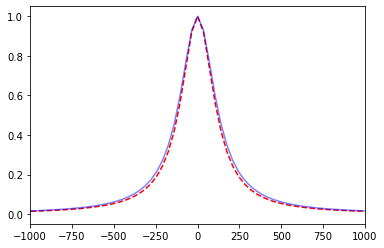

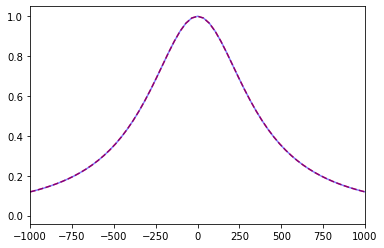

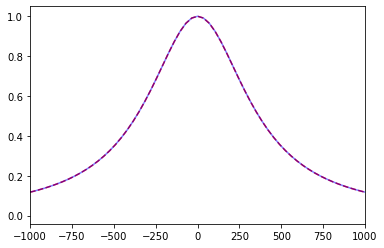

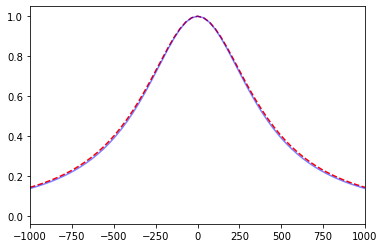

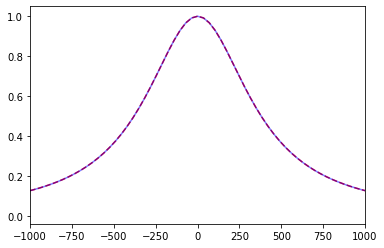

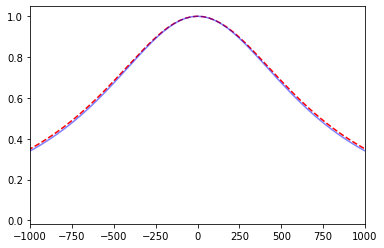

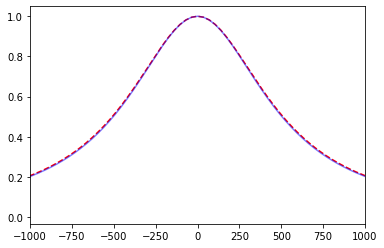

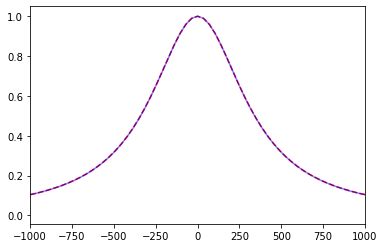

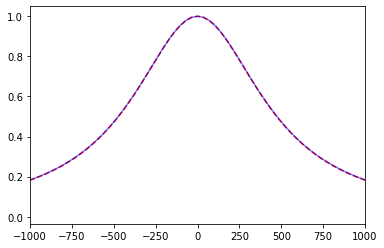

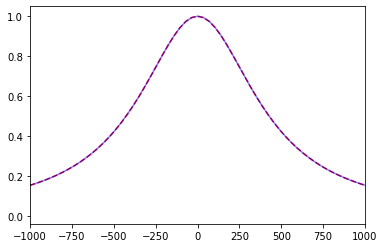

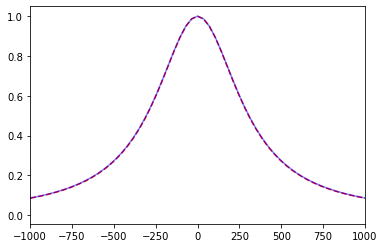

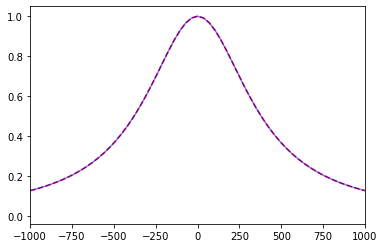

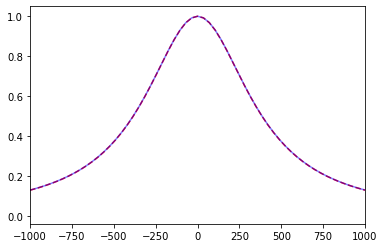

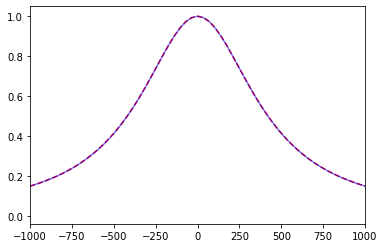

In [51]:
curvefit_MAE_list = []

for i in range(len(test_inds)):
    
    df_ind = test_inds[i]
    
    alltime = all_times[df_ind]
    true_params = popts_cauchy[df_ind]
    cff0 = cff_df.loc[df_ind, 'cff0']
    
    pred_params = predicted_param[i]
     
    predicted_curve = cauchy(alltime, pred_params)
    true_curve = cauchy(alltime, true_params)
    
    MAE = sklearn.metrics.mean_absolute_error(predicted_curve, true_curve)
    print(MAE)
    curvefit_MAE_list.append(MAE)
    
    plt.figure()
    plt.plot(alltime, true_curve, 'r--')
    plt.plot(alltime, predicted_curve,'-b', alpha = 0.5)
    plt.xlim([-1000,1000])
    

### Predictions vs true Cff 

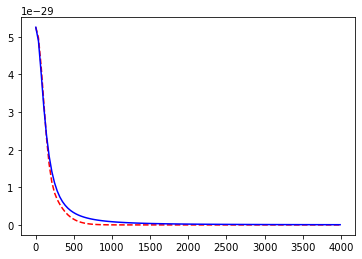

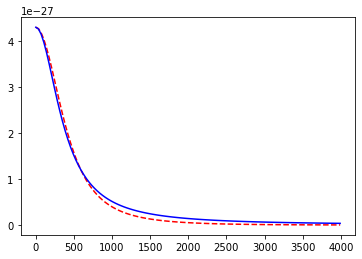

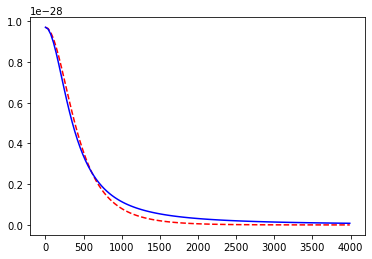

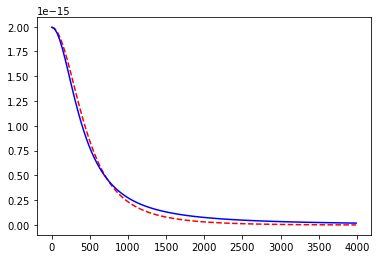

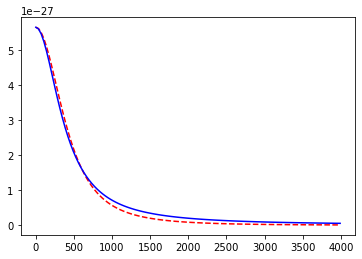

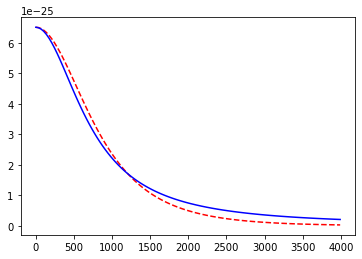

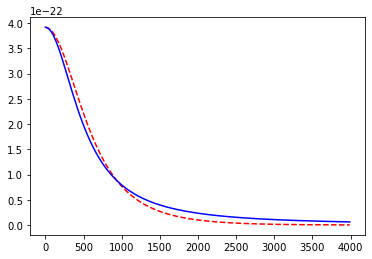

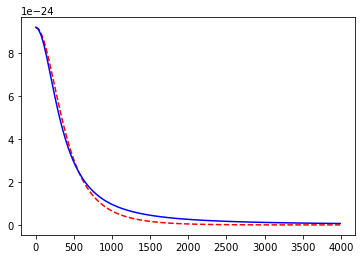

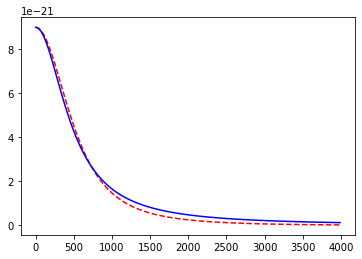

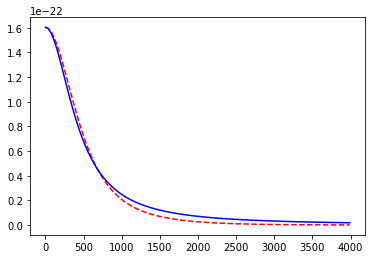

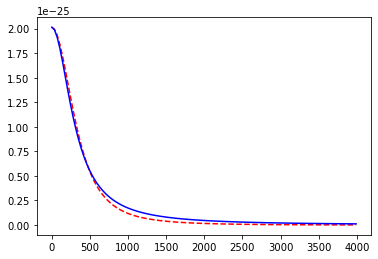

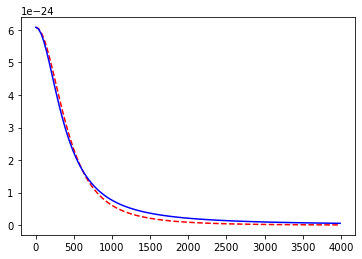

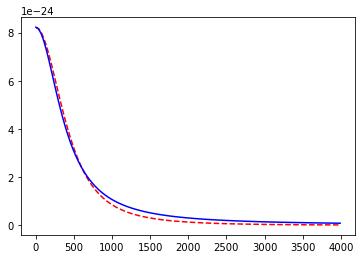

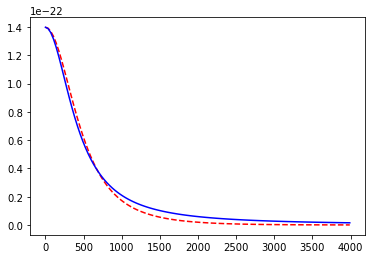

In [52]:
cff_MAE_list = []
cff_MAPE_list = []

for i in range(len(test_inds)):
    
    df_ind = test_inds[i]
    
    alltime = np.array(all_times[df_ind])
    cffvals = cff_df.loc[df_ind, 'cffvals_unscaled']
    cff0 = cff_df.loc[df_ind, 'cff0']
    
    pred_params = predicted_param[i]
    
    predicted_curve = cauchy(alltime, pred_params)*cff0
    
    time = alltime[alltime>=0]
    pred_cff = predicted_curve[alltime>=0]
    
    MAE = sklearn.metrics.mean_absolute_error(cffvals, pred_cff)
    MAPE = sklearn.metrics.mean_absolute_percentage_error(cffvals, pred_cff)*100
    
    cff_MAE_list.append(MAE)
    cff_MAPE_list.append(MAPE)
    
    plt.figure()
    plt.plot(time, cffvals, 'r--')
    plt.plot(time, pred_cff,'-b')
    #plt.xlim([-100,1000])
    

In [53]:
print('"mean Cff MAE" :', np.mean(cff_MAE_list))
print("Mean MAPE: (Table 3) ", np.mean(cff_MAPE_list))

"mean Cff MAE" : 2.987176764696766e-18
Mean MAPE: (Table 3)  0.977817109991242


### Integrated predicted Cff(t) vs true kQ

In [54]:
def integrate_predictions(cff_preds, times, cff0):
    CFFint = 0
    
    for i in range(0, len(cff_preds)):
        if i ==0:
            CFFnow = cff_preds[i]
            t = times[i]
            CFFlast = cff0
            tlast = 0
        else:
            CFFnow = cff_preds[i]
            CFFlast = cff_preds[i-1]
            t = times[i]
            tlast = times[i-1]
            
        CFFint+=((CFFnow+CFFlast)/2)*(t - tlast)
        
    return CFFint

In [55]:
integrated_list = []

for i in range(len(test_inds)):
    
    df_ind = test_inds[i]
    
    cff0 = cff_df.loc[df_ind, 'cff0']
    
    pred_params = scale[i]
    
    predicted_curve = cauchy(alltime, pred_params)
    
    time = alltime[alltime>=0]
    pred_cff = predicted_curve[alltime>=0]
    pred_cff = pred_cff*cff0
    
    integrated_prediction = integrate_predictions(pred_cff, time, cff0)
    
    integrated_list.append(integrated_prediction)

In [56]:
y_test = kQ_true[test_inds]

Text(0, 0.5, '$\\log(kQ_{C{ff}})$, Curve Fit integration')

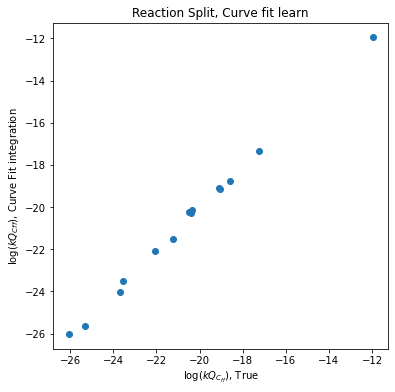

In [57]:
plt.figure(figsize = (6,6))

plt.scatter(np.log10(y_test), np.log10(integrated_list))
plt.title('Reaction Split, Curve fit learn')
plt.xlabel(r'$\log(kQ_{C_{ff}})$, True')
plt.ylabel(r'$\log(kQ_{C{ff}})$, Curve Fit integration')

In [58]:
sklearn.metrics.r2_score(np.log10(y_test), np.log10(integrated_list))

0.9969831093828379

In [59]:
sklearn.metrics.mean_absolute_error(np.log10(y_test), np.log10(integrated_list))

0.14504753967387657

In [60]:
kq_mape = sklearn.metrics.mean_absolute_percentage_error(np.log(y_test), np.log(integrated_list))*100
print('Integrated rate constant mape (table 3): ', kq_mape)

Integrated rate constant mape (table 3):  0.6784178467497437
